# Analysis of 77084 zip code using Facebook Prophet

# Imports and loading csv

In [15]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
#Supress default INFO logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
logging.disable(sys.maxsize)
from fbprophet.diagnostics import cross_validation

In [16]:
df=pd.read_csv('df_zillow_77036_prepped_fbprophet.csv')

In [17]:
df.head()

,ds,y
0,1996-04,120400.0
1,1996-05,118700.0
2,1996-06,117300.0
3,1996-07,116100.0
4,1996-08,115300.0


# Plotting the specific zip code data from csv

Text(0, 0.5, 'Home Values')

<Figure size 432x288 with 0 Axes>

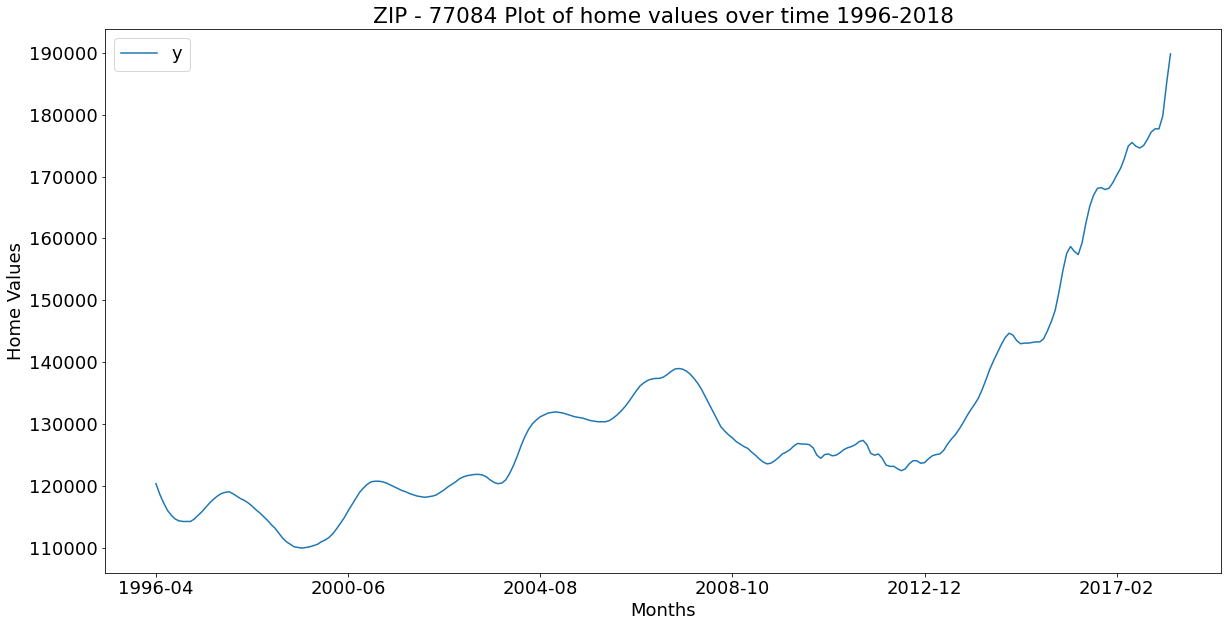

In [18]:
plt.figure()
plt.rcParams.update({'font.size': 18})
ax = df.plot(title='ZIP - 77084 Plot of home values over time 1996-2018', figsize=(20,10), x='ds')
ax.set_xlabel('Months')
ax.set_ylabel('Home Values')

# Fitting and forecasting the model
    1. The length of the forecast will be 5 years into the future.
    2. Periods = 60 with freq = M
        - 60 months / 12 months per year  = 5 years
    3. seasonality_mode = multiplicative
        - This is because additive would mean our graph will have a STEADY upward climb
        - This is not the case. There is a HUGE upward climb. Thus, multiplicative was used instead of additive.
        
### Observations:
    1. The trend shows promise, reflects the growth and demand of properties in the area.
    2. The 2008 crash is reflected in the dip in home prices. This should not be confused for a cyclical occurence.
    3. We cannot say much about seasonality. There is a huge upward trend.
        - Future work - maybe find stronger seasonality in daily data instead of monthly.

<Figure size 432x288 with 0 Axes>

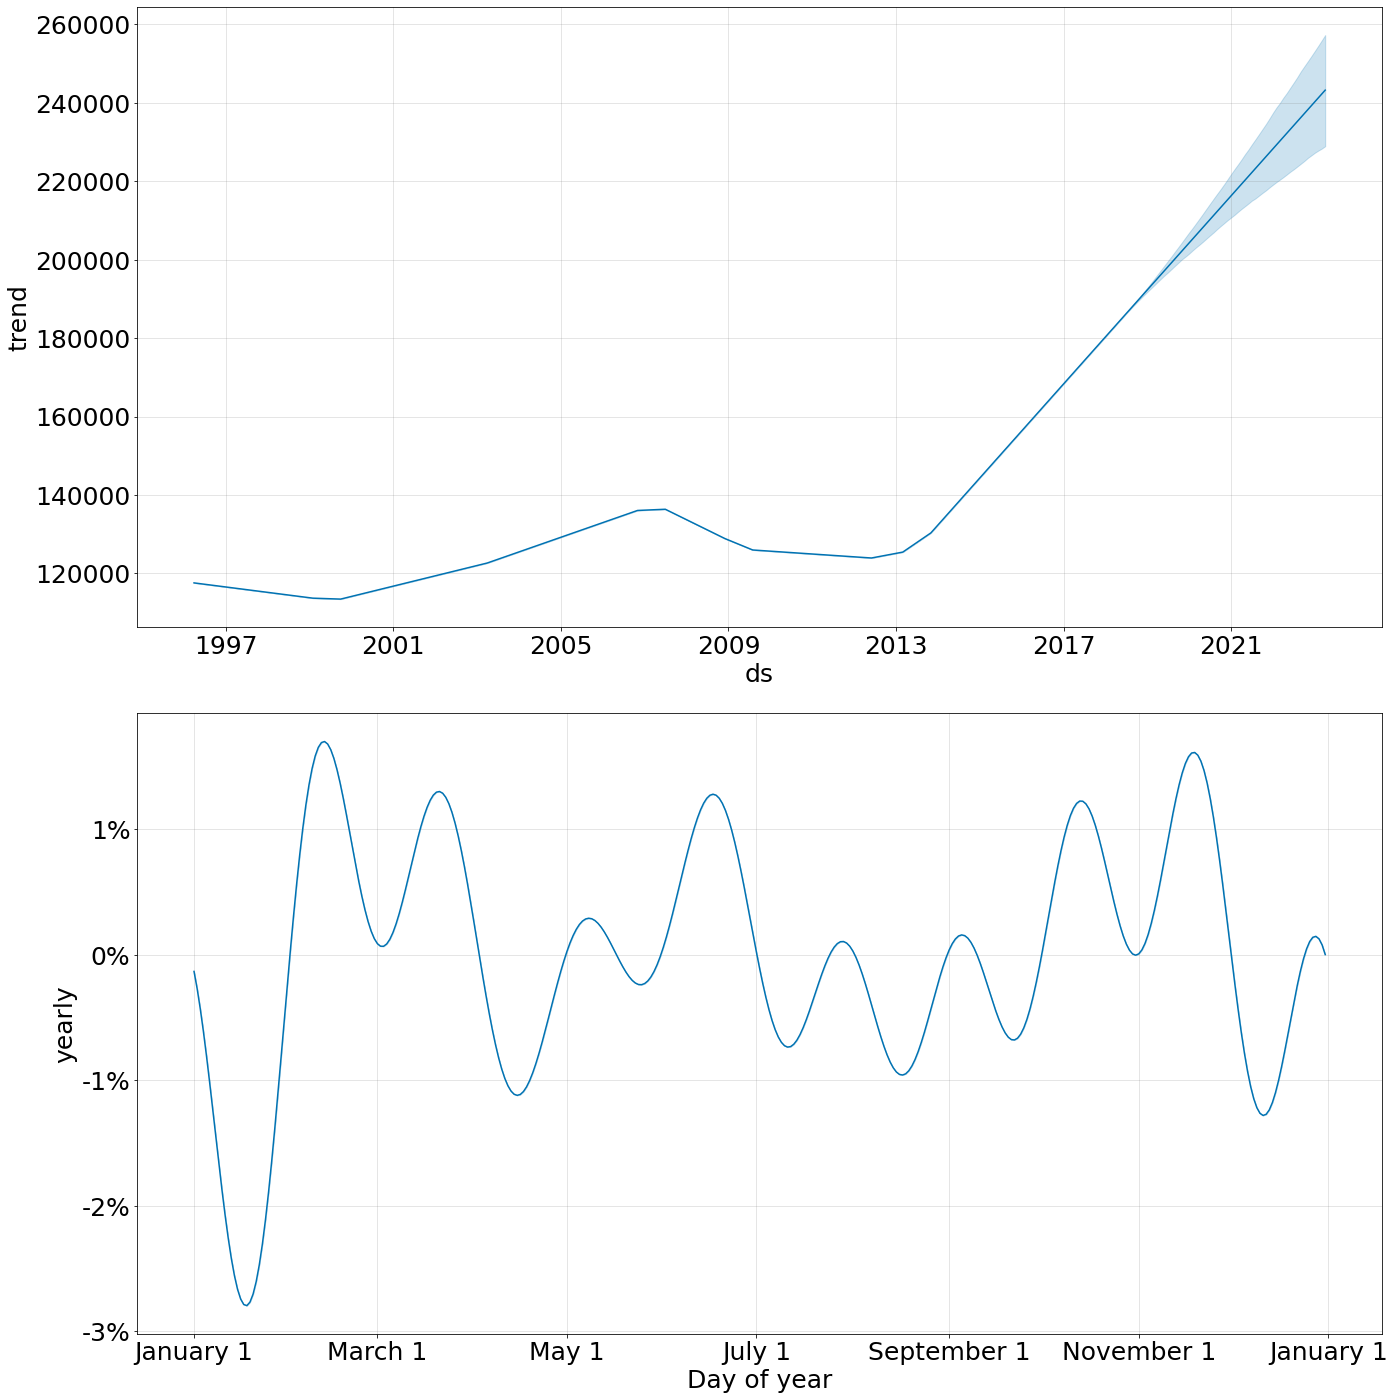

In [59]:
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=60, freq='M')
fcst = m.predict(future)
plt.figure()
plt.rcParams.update({'font.size': 25})
fig = m.plot_components(fcst, figsize=(20,20))

In [20]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
320,2022-11-30,239752.377357,227192.724227,253807.770571
321,2022-12-31,240330.026404,227251.264081,254609.143032
322,2023-01-31,240351.701164,226088.107839,254519.382690
323,2023-02-28,242589.706862,228793.331413,257393.430233
324,2023-03-31,244430.805296,230142.787161,259867.610543


# Forecast Model Diagnostics
## Here I will check the accuracy of the model using cross validation
### Cross validation parameters are as follows:
    1. Model will be "m" from above fitted by Prophet() method
    2. The initial training lengh parameter will be 5475 days or 15 years (365*15 = 5475)
        - This means cutoff will be after 15 years (1996 - 2011)
    3. The horizon will be 1825 days or 5 years (365 * 5 = 1825)
        - from 2012 - 2017
    4. The period is set to 180 days
        - Means it will make a prediction roughly every 6 months        

In [68]:
cv_results = cross_validation( model = m, initial = pd.to_timedelta(5475, unit="d"),period="180 days", horizon = pd.to_timedelta(1825,unit="d"))

In [69]:
cv_results.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-05-01,121353.962411,118352.711476,124250.033754,126400.0,2011-04-13
1,2011-06-01,121231.089586,118219.735985,124355.673073,126700.0,2011-04-13
2,2011-07-01,121085.778066,117962.351633,124338.769554,127200.0,2011-04-13
3,2011-08-01,120671.920661,117584.307955,123794.291564,127400.0,2011-04-13
4,2011-09-01,120298.022689,116852.501093,123349.338971,126700.0,2011-04-13


### MSE observation:
    1. MSE starts to increase exponentially after 750-1000 days. 
    2. This reflects higher uncertainty the farther into the horizon

<Figure size 432x288 with 0 Axes>

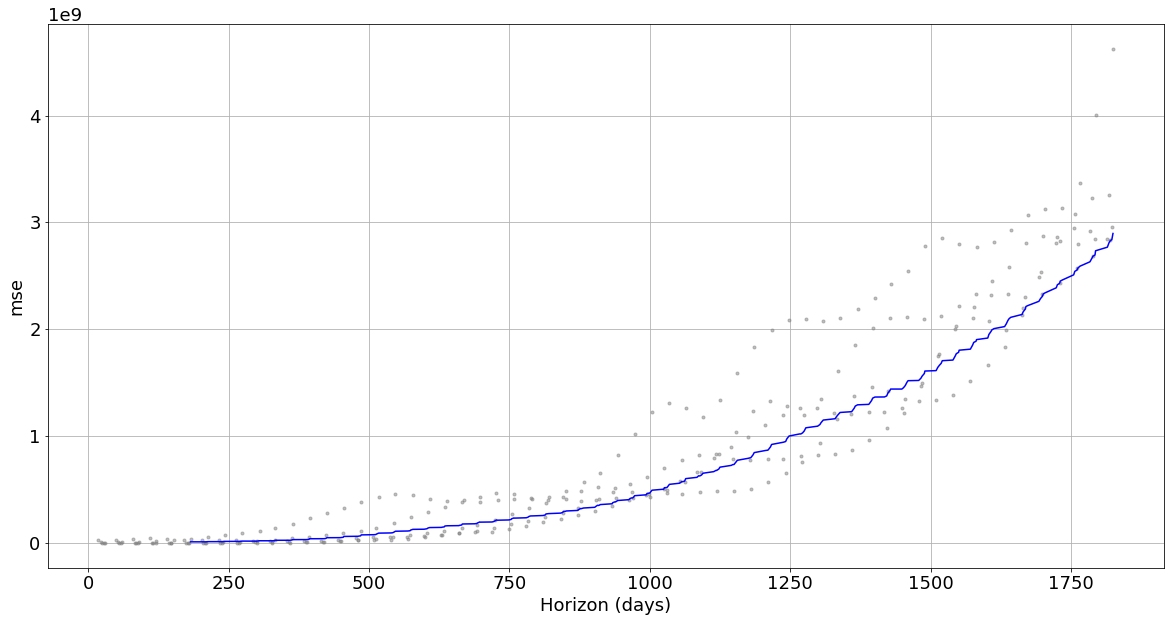

In [70]:
from fbprophet.plot import plot_cross_validation_metric
plt.figure()
plt.rcParams.update({'font.size': 18})
fig = plot_cross_validation_metric(cv_results, metric='mse', figsize=(20,10))

### RMSE Observation:
    1. Similar to MSE, the error increases with longer time into horizon

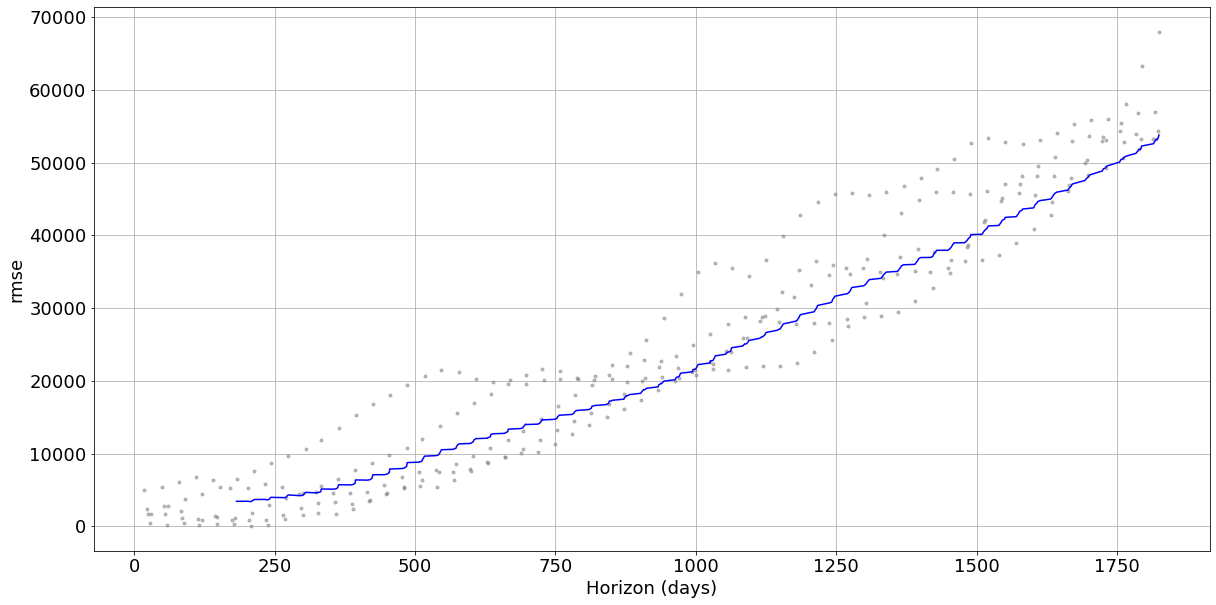

In [95]:
fig = plot_cross_validation_metric(cv_results, metric='rmse', figsize=(20,10))

### MAE - Mean Absolute Error Observation:
    1. Similar to MSE and RMSE, the difference starts increasing as the number of observations are increasing

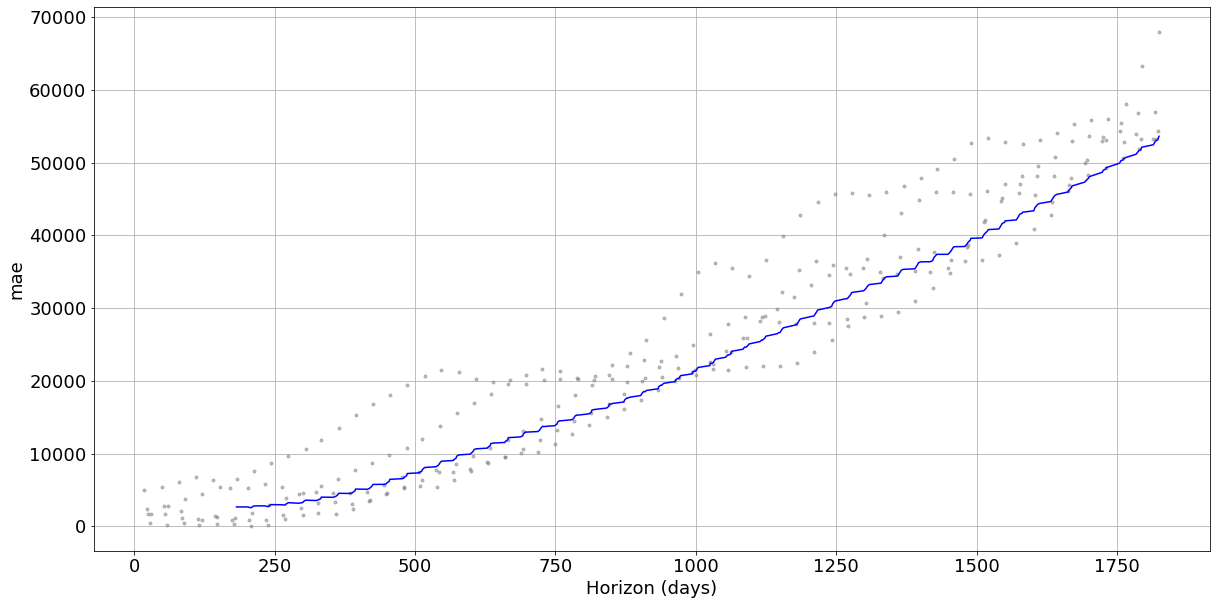

In [72]:
fig = plot_cross_validation_metric(cv_results, metric='mae', figsize=(20,10))

## MAPE (Mean Average Percent Error) - Observation:
    1. We see that MAPE increases over time
    2. I am willing to tolerate MAPE of 0.1 to 0.2
        - This gets exceeded after about 1100 days        
    3. We will focus on MAPE as our main diagnostic metric.
        - Shows the model was about 85% accurate at 1000 days
        - Bullish prediction for the next 2-3 years
        - Supports the high upward trend we saw in the graph of all the data points for the zip code

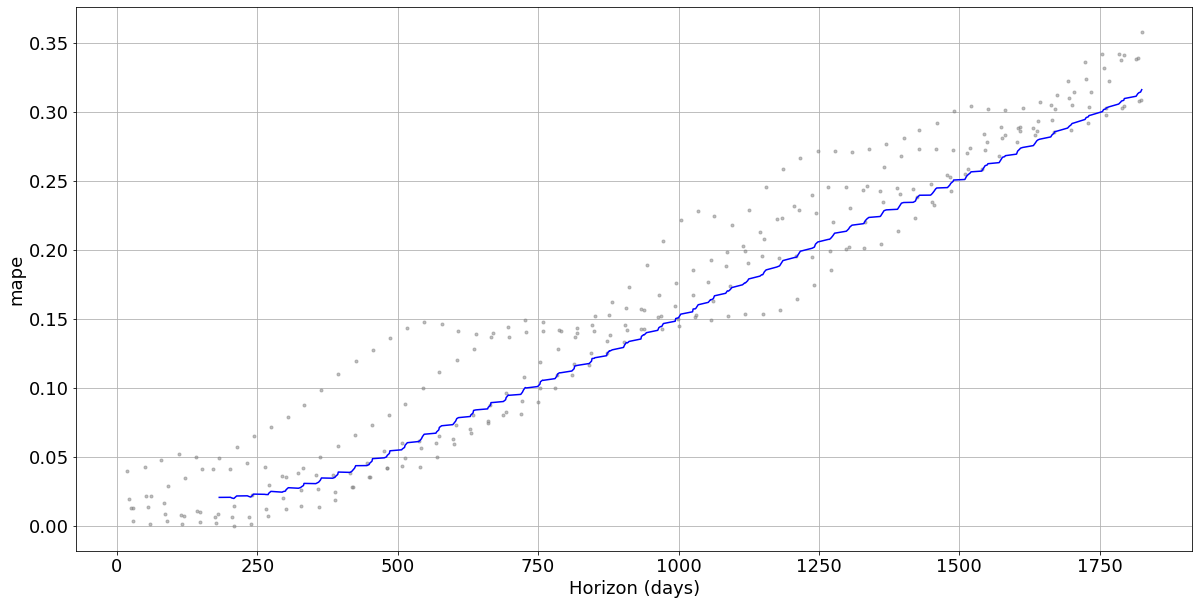

In [73]:
fig = plot_cross_validation_metric(cv_results, metric='mape', figsize=(20,10))

### Coverage Observation:
    1. We see coverage decreasing over time of horizon
    2. Shows 0 probability as we go past 500 days. 
    3. Means after about 500 days there is no probability a true value will be in the predicted range. 
    4. This does not fully explain anything. Just shows the values are not in the predicted range after some time.

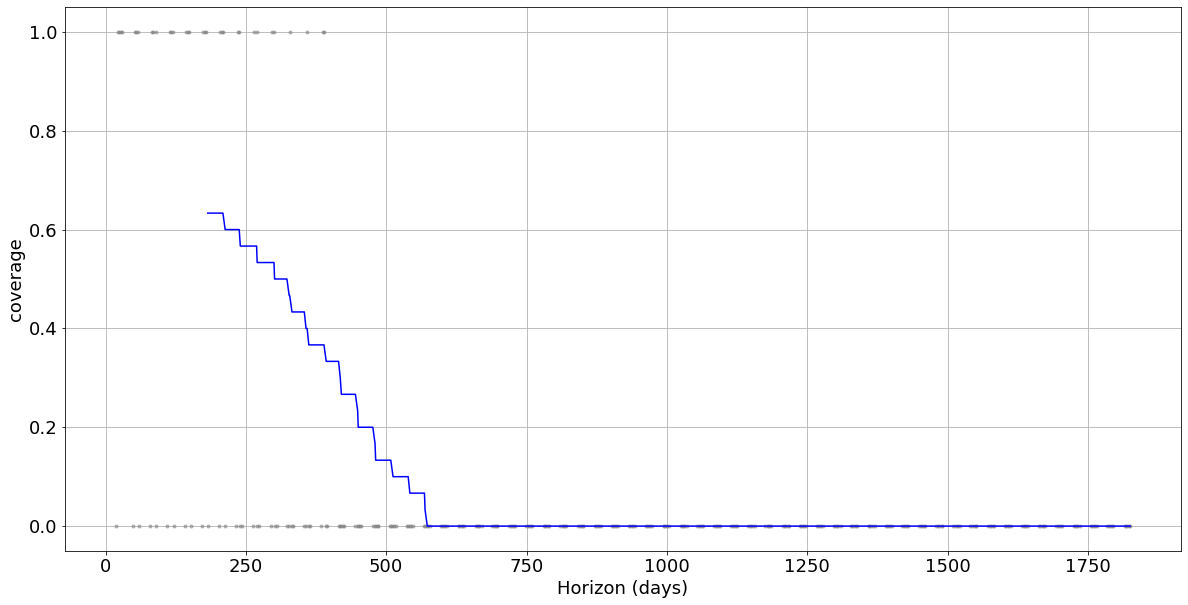

In [74]:
fig = plot_cross_validation_metric(cv_results, metric='coverage', figsize=(20,10))